In [34]:
import os
import sys
import pickle

from time import sleep
from time import time
from random import randint

import tensorflow as tf
import cv2
import numpy as np
#import mpld3

from matplotlib import pyplot as plt
%matplotlib inline
from sklearn import svm
from sklearn.utils import shuffle

IMG_SIZE = (64, 64) # Size of image
NUM_CHANNELS = 3 # RGB
PIXEL_DEPTH = 255.0  # Number of levels per pixel.

### Dataset routines ###

In [62]:
def accuracy_func(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
            / predictions.shape[0])

def make_feature_vec(img):
    """Resize an 'img' to correct size and make a vector ((60, 60, 3) => (64, 64, 3))"""
    if img.shape[:2] != IMG_SIZE:
        img = cv2.resize(img, IMG_SIZE)
    return normalize(img.reshape(1, IMG_SIZE[0], IMG_SIZE[1], NUM_CHANNELS))

def load_dataset(path, dataset_size=-1, downsample=False):
    """Loads samples from image files (e.g '001.png').
    Args:
        path -- path to the images(samples) (default size: 60px X 60px)
        dataset_size -- number of samples to read
        downsample -- downsamples input sample(img) if True
    Returns:
        images -- array (n, 60, 60, 1) of sample vectors as rows
    """
    image_files = os.listdir(path)[:dataset_size]
    # Init 'images' array as samples X features matrix
    images = np.ndarray(shape=(len(image_files), IMG_SIZE[0], IMG_SIZE[1], NUM_CHANNELS), 
                        dtype=np.float32)
    image_idx = 0
    for filename in image_files:
        if NUM_CHANNELS == 3:
            color_mode = cv2.IMREAD_COLOR
        else:
            color_mode = cv2.IMREAD_GRAYSCALE
        img = cv2.imread(os.path.join(path, filename), color_mode)
        if downsample:
            # Downsample image (scale down by 50%)
            img = cv2.pyrDown(img)
        if img.shape[0] / img.shape[1] != IMG_SIZE[0] / IMG_SIZE[1]:
            continue
        # Convert img matrix to proper format vector (n, IMG_SIZE[0], IMG_SIZE[1], NUM_CHANNELS)
        # Normalize (mean=0, stdev~=0.5)
        images[image_idx, :] = make_feature_vec(img)
        image_idx += 1
    return images

def label_dataset(pos_data, neg_data):
    """Prepare dataset. Combime pos and neg examples, label it & shuffle it.
    Args:
        pos_data -- array of positive samples
        neg_data -- array of negative samples
    Returns:
        dataset -- samples array
        labels -- labels vec
    """
    num_pos_samples = pos_data.shape[0]
    num_neg_samples = neg_data.shape[0] 
    num_total = num_pos_samples + num_neg_samples
    dataset = np.vstack((pos_data, neg_data[:num_neg_samples])).astype(np.float32)
    
    # Label as 1-hot encoding 
    # ex. np.array([1, 0], dtype=np.float32) -- positive
    # ex. np.array([0, 1], dtype=np.float32) -- negative
    
    num_classes = 2 # pos, neg
    labels = np.ndarray(shape=(num_total, num_classes), dtype=np.float32)
    labels[:num_pos_samples] = np.array([1, 0]) # positive
    labels[num_pos_samples:] = np.array([0, 1]) # negative
    
    # Shuffle
    return shuffle(dataset, labels, random_state=0)

def normalize(img):
    """Normalize to have approximately zero mean and standard deviation ~0.5 
    to make training easier down the road. 
    """
    mean = PIXEL_DEPTH / 2
    return (img - mean) / PIXEL_DEPTH

def preview(sample_vec):
    %matplotlib inline
    #mpld3.enable_notebook()
    plt.imshow(sample_vec.reshape(IMG_SIZE + (NUM_CHANNELS,)))
    
def preview_random_examples(pos_data, neg_data):
    %matplotlib inline
    #mpld3.enable_notebook()
    plt.figure(1)
    pos_idx = randint(1, len(pos_data))
    plt.title('POSITIVE (ex. #{})'.format(pos_idx))
    plt.imshow(pos_data[pos_idx].reshape(IMG_SIZE + (NUM_CHANNELS,)))

    plt.figure(2)
    neg_idx = randint(1, len(neg_data))
    plt.title('NEGATIVE (ex.#{})'.format(neg_idx))
    plt.imshow(neg_data[neg_idx].reshape(IMG_SIZE + (NUM_CHANNELS,)))
    plt.show()

### Load positive and negative examples from files into feature vectors ###

In [63]:
pos_path = './dataset/positive/'
neg_path = './dataset/negative/'
pos_data = load_dataset(path=pos_path)
neg_data = load_dataset(path=neg_path) #dataset_size=700)
dataset, labels = label_dataset(pos_data, neg_data)

In [61]:
IMG_SIZE + (3,)

(64, 64, 3)

Number of POSITIVE samples: 628

Number of NEGATIVE samples: 2724



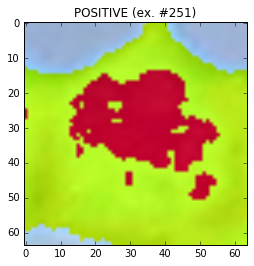

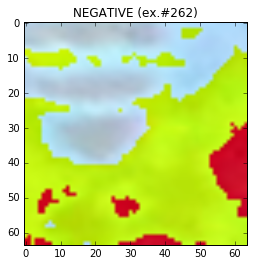

In [78]:
print('Number of POSITIVE samples: %d\n' % len(pos_data))
print('Number of NEGATIVE samples: %d\n' % len(neg_data))
preview_random_examples(pos_data, neg_data)

### Spilt data to training, validation and test sets (60%, 20%, 20%) ###

In [79]:
idx_train = int(dataset.shape[0] * 0.6)
idx_cv = idx_train + int(dataset.shape[0] * 0.2)
train_dataset = dataset[:idx_train]
train_labels = labels[:idx_train]
valid_dataset = dataset[idx_train:idx_cv]
valid_labels = labels[idx_train:idx_cv]
test_dataset = dataset[idx_cv:]
test_labels = labels[idx_cv:]

del dataset
del labels

#print('No samples missed during spliting: {}'.format(len(labels) == len(train_labels) + len(valid_labels) + len(test_labels)))
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

('Training set', (2011, 64, 64, 3), (2011, 2))
('Validation set', (670, 64, 64, 3), (670, 2))
('Test set', (671, 64, 64, 3), (671, 2))


### ============================================================= ###
### Convolutional Neural Network ###
Create CNN with custom architecture.
- CONV1
- RELU1
- POOL1
- CONV2
- RELU2
- POOL2
- FC1
- RELU3
- FC2

In [80]:
### ConvNet with max pooling

batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

log_dir = './log'
num_labels = 2

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, IMG_SIZE[0], IMG_SIZE[1], NUM_CHANNELS))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    tf_single_sample = tf.placeholder(tf.float32, shape=(1, IMG_SIZE[0], IMG_SIZE[1], NUM_CHANNELS))

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, NUM_CHANNELS, depth], stddev=0.1))
    # [5, 5, 1, 16]
    layer1_biases = tf.Variable(tf.zeros([depth]))

    layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
    # [5, 5, 16, 16]
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    layer3_weights = tf.Variable(tf.truncated_normal(
      [IMG_SIZE[0] // 8 * IMG_SIZE[1] // 8 * depth, num_hidden], stddev=0.1))
    # [1024, 64]
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
    # [64, 2]
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

    # Model.
    def model(data):
        conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        hidden = tf.nn.max_pool(hidden, [1, 4, 4, 1], [1, 4, 4, 1], padding='SAME')

        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        hidden = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')

        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)

        return tf.matmul(hidden, layer4_weights) + layer4_biases

    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    # Optimizer + LR decay.
    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.005, global_step, 100, 0.96) 
    # Get test set accuracy of 95.0%
    # (0.05, global_step, 1000, 0.96)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    # Optimizer.
    #optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))
    sample_prediction = tf.nn.softmax(model(tf_single_sample))

In [81]:
IMG_SIZE[0] // 8 * IMG_SIZE[1] // 8 * depth

1024

### Goto 'Restore the model and run prediction' if you do no want to train a new CNN. ###
### =================================================== ###

### Train CNN  ###
Train & save trained model to file './models/model_[accuracy].ckpt'

In [82]:
num_steps = 1001 #10001
num_fetch_results = 50
acc_list = []

with tf.Session(graph=graph) as session:    
    tf.initialize_all_variables().run()
    print('Initialized')

    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()

    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % num_fetch_results == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy_func(predictions, batch_labels))
            val_accuracy = accuracy_func(valid_prediction.eval(), valid_labels)
            print('Validation accuracy: %.1f%%' % val_accuracy)
            acc_list.append(val_accuracy)
    test_accuracy = accuracy_func(test_prediction.eval(), test_labels)
    print('Test accuracy: %.1f%%' % test_accuracy)
    
    # Save variables to file
    tf_model_filename = ("model_%.2f.ckpt" % test_accuracy)
    save_path = saver.save(session, "./models/%s" % tf_model_filename)
    print("Model saved in file: %s" % save_path)

Exception AssertionError: AssertionError() in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x7f213f92d910>> ignored
Exception AssertionError: AssertionError() in <generator object get_controller at 0x7f2164e6d5a0> ignored


Initialized
Minibatch loss at step 0: 0.382659
Minibatch accuracy: 87.5%
Validation accuracy: 80.9%
Minibatch loss at step 50: 0.464546
Minibatch accuracy: 75.0%
Validation accuracy: 82.2%
Minibatch loss at step 100: 0.680734
Minibatch accuracy: 68.8%
Validation accuracy: 90.4%
Minibatch loss at step 150: 0.453883
Minibatch accuracy: 81.2%
Validation accuracy: 70.9%
Minibatch loss at step 200: 0.148719
Minibatch accuracy: 100.0%
Validation accuracy: 89.4%
Minibatch loss at step 250: 0.217699
Minibatch accuracy: 87.5%
Validation accuracy: 91.0%
Minibatch loss at step 300: 0.224029
Minibatch accuracy: 87.5%
Validation accuracy: 92.2%
Minibatch loss at step 350: 0.310232
Minibatch accuracy: 93.8%
Validation accuracy: 93.6%
Minibatch loss at step 400: 0.191647
Minibatch accuracy: 87.5%
Validation accuracy: 87.9%
Minibatch loss at step 450: 0.349966
Minibatch accuracy: 93.8%
Validation accuracy: 92.8%
Minibatch loss at step 500: 0.189323
Minibatch accuracy: 87.5%
Validation accuracy: 94.3%


### Plot training curves ###

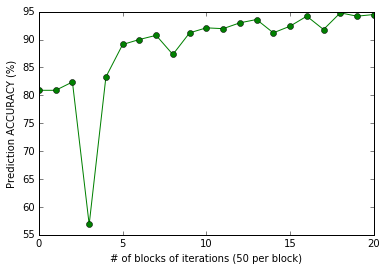

In [221]:
%matplotlib inline
plt.plot(acc_list, '-go')
plt.xlabel('# of blocks of iterations (%s per block)' % num_fetch_results)
plt.ylabel('Prediction ACCURACY (%)')
plt.show()

### =================================================== ###
### Restore the model and run prediction ###

In [7]:
tf_model_filename = 'model_94.19.ckpt'
tf_model_path = './models/%s' % tf_model_filename

In [8]:
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')

    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()
    # Restore model
    saver.restore(session, tf_model_path)
    print("Model restored.")

    feed_dict = {tf_single_sample : [test_dataset[0]]}
    prediction = session.run(
        [sample_prediction], feed_dict=feed_dict)

Initialized
Model restored.


In [21]:
prediction

[array([[ 0.00112501,  0.99887496]], dtype=float32)]

### Detect capped brood cells on WHOLE image ###
Use classifier on each single sample subimage, acquired with sliding window.
(Remember to normalize before prediction!!!)

In [83]:
def draw_circle(img, x, y, color):
    cv2.circle(img=img,
               center=(x + WIN_SIZE // 2, y + WIN_SIZE // 2), 
               radius=WIN_SIZE // 2, 
               color=color,
               thickness=2)
    return img

def draw_rect(img, x, y, color):
    cv2.rectangle(img=img, 
                  pt1=(x, y), 
                  pt2=(x + WIN_SIZE, y + WIN_SIZE), 
                  color=color, 
                  thickness=2)
    return img
    
def draw_dot(img, x, y, color):
    cv2.putText(img=img, 
                text='.', 
                org=(x, y + IMG_SIZE[0]),        # TOP LEFT corner if bottomLeftOrigin=False
                fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
                fontScale=4, 
                color=color, 
                thickness=1, 
                bottomLeftOrigin=False)
    return img

def show(win_name, img):
    cv2.imshow(win_name, img)
    key_pressed = cv2.waitKey(1)
    return key_pressed

def sliding_window_to_feature_vec(image, stepSize, windowSize):
    # slide a window across the image
    for y in xrange(0, image.shape[0], stepSize):
        for x in xrange(0, image.shape[1], stepSize):
            # yield the current window
            window = image[y:y + windowSize[1], x:x + windowSize[0]]
            yield (x, y, np.array(make_feature_vec(window)))

In [88]:
# Parameters
FILENAME = '025.png'
PATH = '/home/chip/Dropbox/LITS/ML-003/dataset/processed_dataset/prespective_correction'

WIN_SIZE = 50
STEP = 50
PRED_THRESHOLD = 0.8
WIN_NAME = 'img'
VISUAL = True  # Visualize detection process (INCREASES RUNTIME)

tf_model_filename = 'model_95.98.ckpt'
tf_model_path = './models/%s' % tf_model_filename

In [89]:
img_path = os.path.join(PATH, FILENAME)
# Read COLOR img to predict on and COLOR one to show result
#img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img = img_rgb = cv2.imread(img_path, cv2.IMREAD_COLOR)
img_height, img_width = img.shape[:2]

# Create sliding window generator
samples_gen = sliding_window_to_feature_vec(image=img,
                                            stepSize = STEP,
                                            windowSize=(WIN_SIZE, WIN_SIZE))
cv2.namedWindow(WIN_NAME, cv2.WINDOW_NORMAL)


# Restore tf session
session = tf.InteractiveSession(graph=graph)

tf.initialize_all_variables().run()
print('Initialized')

# Restore model
saver.restore(session, tf_model_path)
print("Model restored.")


# Iterate through all the generated samples
for x, y, sample in samples_gen:
    feed_dict = {tf_single_sample : sample}
    prediction = session.run(
        [sample_prediction], feed_dict=feed_dict)
    if x == img_width // 2:
        print(prediction)
        plt.imshow(sample.reshape(IMG_SIZE))
    if prediction[0][0][0] > PRED_THRESHOLD:
        draw_circle(img_rgb, x, y, (0, 255, 0))
    else:
        draw_dot(img_rgb, x, y, (0, 0, 255))
    if VISUAL:
        key = show(WIN_NAME, img_rgb)
        if key == ord('q'):
            break
while show(WIN_NAME, img_rgb) != ord('q'):
    pass
cv2.destroyAllWindows()

Exception AssertionError: AssertionError() in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x7f21460acf50>> ignored


Initialized
Model restored.
